# LSTM for Stock Price Prediction

---


We will evaluate our models on several axis: First, prediction performance on the test data set. Second, the variance of our models predictions over the variance of the underlying test data. Third, the speed of training and inference, and lastly but related, the number of parameters in our model.

Evaluation Metrics:

For prediction performance: Mean Absolute Percentage Error (MAPE).
Specific implementation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

For uncertainty: np.var('our predictions') / np.var('actual data')

For speed: seconds of runtime.
Specific implementation: https://docs.python.org/3/library/timeit.html

Implementation steps:

1. Set up our helper classes (`ETL`, `PredictAndForecast`, `Evaluate`). ✅
2. Implement an LSTM as a baseline.✅
3. Train our models and use them for inference, measuring performance as we go.✅
4. Evaluate our models' performances against our test set. ✅
5. Visualize our predictions as a sanity check.✅

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

In [2]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [3]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)

In [4]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [5]:
data = ETL('^GSPC')

## 2. Implementing an LSTM baseline

In [6]:
def build_lstm(etl: ETL, epochs=25, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits our LSTM baseline model.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs))
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
  print('fitting model...')
  start = time.time()
  history = model.fit(etl.X_train, etl.y_train, batch_size=batch_size, epochs=epochs, validation_data=(etl.X_test, etl.y_test), verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return model, history

In [7]:
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/25
603/603 [==============================] - 4s 6ms/step - loss: 2470.1865 - mae: 9.1643 - mape: 4.9495 - val_loss: 5958.3677 - val_mae: 57.8928 - val_mape: 2.6403
Epoch 2/25
603/603 [==============================] - 3s 5ms/step - loss: 167.1844 - mae: 5.1853 - mape: 2.6210 - val_loss: 3112.7944 - val_mae: 35.4507 - val_mape: 1.6592
Epoch 3/25
603/603 [==============================] - 3s 5ms/step - loss: 123.4965 - mae: 4.4575 - mape: 2.2708 - val_loss: 5938.8589 - val_mae: 54.3020 - val_mape: 2.5694
Epoch 4/25
603/603 [==============================] - 3s 5ms/step - loss: 136.9385 - mae: 4.7140 - mape: 2.4101 - val_loss: 5092.1343 - val_mae: 53.5594 - val_mape: 2.4413
Epoch 5/25
603/603 [==============================] - 3s 5ms/step - loss: 134.9389 - mae: 4.6990 - mape: 2.3778 - val_loss: 3204.7825 - val_mae: 37.6474 - val_mape: 1.7434
Epoch 6/25
603/603 [==============================] - 3s 5ms/step - loss: 120.1252 - mae: 4.33

In [8]:
baseline_model = baseline[0]
history = baseline[1]

In [9]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 171905 (671.50 KB)
Trainable params: 171905 (671.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Inference on our Models

In [10]:
start = time.time()
baseline_preds = PredictAndForecast(baseline_model, data.train, data.test)
print(time.time() - start)

26.268393993377686


In [11]:
baseline_evals = Evaluate(data.test, baseline_preds.predictions)

In [12]:
baseline_evals.mape, baseline_evals.var_ratio

(0.014148812959626026, 0.005904298534986752)

# 5. Visualizing

In [13]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='^GSPC stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

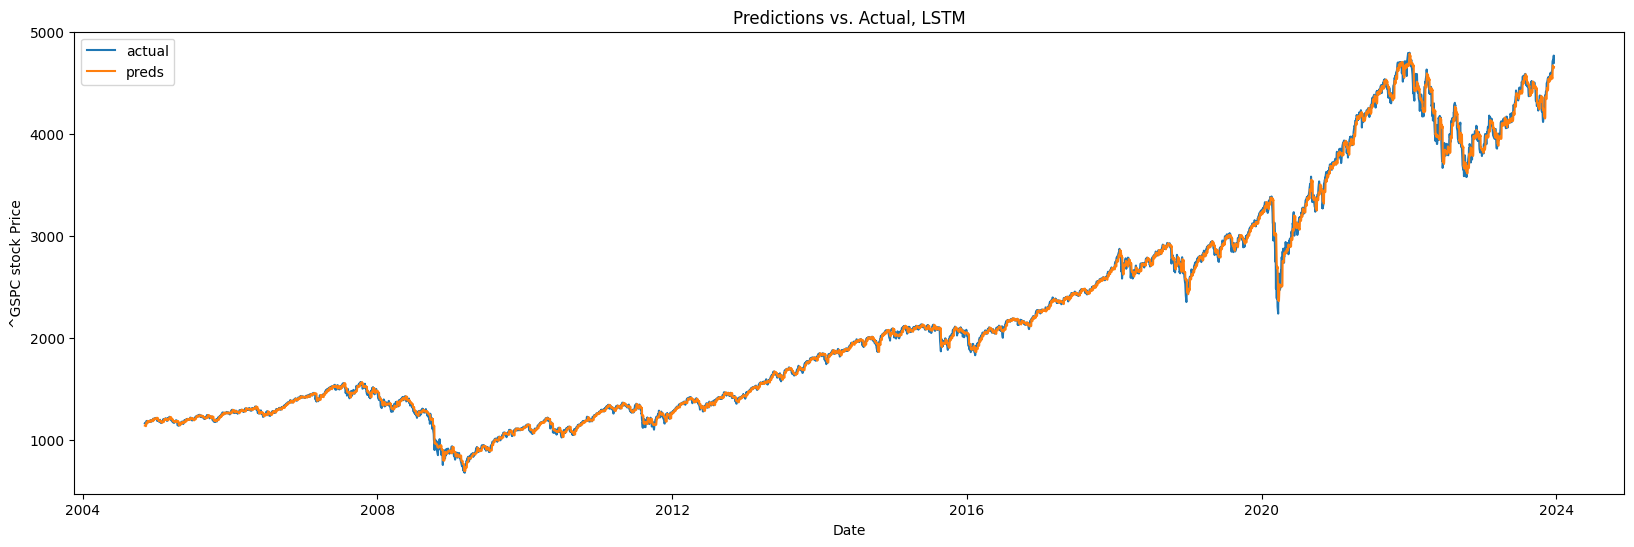

In [14]:
plot_results(data.test, baseline_preds.predictions, data.df, title_suffix='LSTM')